# Session 4: ARIMA Models - Fundamentals

## Summer School: Time Series Methods for Finance and Economics

### Learning Objectives

By the end of this session, you will be able to:
1. Understand AR, MA, and ARMA processes and their properties
2. Apply the Box-Jenkins methodology for ARIMA modeling
3. Identify model orders using ACF and PACF patterns
4. Estimate and diagnose ARIMA models
5. Test for stationarity and apply differencing
6. Generate forecasts with ARIMA models
7. Apply ARIMA to financial returns and economic data

### Prerequisites
- Session 1: Introduction to Time Series Analysis
- Session 2: Classical Decomposition and Smoothing
- Session 3: ETS Models
- Understanding of stationarity and autocorrelation

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Set random seed for reproducibility
np.random.seed(42)

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.precision', 4)

## 1. Autoregressive (AR) Processes

### 1.1 AR(1) Process

An **AR(1)** process is defined as:

$$y_t = c + \phi_1 y_{t-1} + \epsilon_t$$

where:
- $c$ is a constant
- $\phi_1$ is the AR parameter
- $\epsilon_t \sim WN(0, \sigma^2)$ is white noise

**Stationarity condition**: $|\phi_1| < 1$

**Properties**:
- Mean: $\mu = \frac{c}{1-\phi_1}$ (if $c \neq 0$)
- Variance: $\gamma_0 = \frac{\sigma^2}{1-\phi_1^2}$
- Autocorrelation: $\rho_k = \phi_1^k$ (exponential decay)

### 1.2 AR(p) Process

The general **AR(p)** process:

$$y_t = c + \phi_1 y_{t-1} + \phi_2 y_{t-2} + \cdots + \phi_p y_{t-p} + \epsilon_t$$

**Lag operator form**:
$$\phi(L)y_t = c + \epsilon_t$$

where $\phi(L) = 1 - \phi_1 L - \phi_2 L^2 - \cdots - \phi_p L^p$

**Stationarity condition**: All roots of $\phi(L) = 0$ must lie outside the unit circle.

### 1.3 ACF and PACF for AR Processes

**Key identification pattern**:
- **ACF**: Decays exponentially (or with damped oscillations)
- **PACF**: Cuts off after lag $p$

This is the **signature** of AR processes and used for model identification.

In [4]:
def simulate_ar(phi, n=500, c=0, sigma=1, burnin=100):
    """
    Simulate AR process.
    
    Parameters:
    -----------
    phi : array-like
        AR coefficients [phi_1, phi_2, ..., phi_p]
    n : int
        Number of observations
    c : float
        Constant term
    sigma : float
        Standard deviation of innovations
    burnin : int
        Burn-in period
    
    Returns:
    --------
    y : np.array
        Simulated series
    """
    # Create AR coefficients array for ArmaProcess
    ar = np.r_[1, -np.array(phi)]  # [1, -phi_1, -phi_2, ...]
    ma = np.array([1])  # No MA component
    
    # Create ARMA process
    ar_process = ArmaProcess(ar, ma)
    
    # Simulate
    y = ar_process.generate_sample(nsample=n+burnin, scale=sigma)
    
    # Add constant and remove burnin
    if c != 0:
        mu = c / (1 - np.sum(phi))
        y = y + mu
    
    return y[burnin:]

# Simulate different AR processes
n = 500

# AR(1) with positive coefficient
ar1_pos = simulate_ar(phi=[0.8], n=n)

# AR(1) with negative coefficient
ar1_neg = simulate_ar(phi=[-0.8], n=n)

# AR(2) process
ar2 = simulate_ar(phi=[0.6, 0.3], n=n)

# Create time series
dates = pd.date_range(start='2020-01-01', periods=n, freq='D')
ts_ar1_pos = pd.Series(ar1_pos, index=dates, name='AR(1): φ=0.8')
ts_ar1_neg = pd.Series(ar1_neg, index=dates, name='AR(1): φ=-0.8')
ts_ar2 = pd.Series(ar2, index=dates, name='AR(2): φ₁=0.6, φ₂=0.3')

print("AR Process Statistics:")
print("="*60)
for ts in [ts_ar1_pos, ts_ar1_neg, ts_ar2]:
    print(f"\n{ts.name}:")
    print(f"  Mean: {ts.mean():.4f}")
    print(f"  Std Dev: {ts.std():.4f}")
    print(f"  Min: {ts.min():.4f}")
    print(f"  Max: {ts.max():.4f}")

AR Process Statistics:

AR(1): φ=0.8:
  Mean: 0.0215
  Std Dev: 1.5775
  Min: -3.7772
  Max: 4.5296

AR(1): φ=-0.8:
  Mean: 0.0608
  Std Dev: 1.7488
  Min: -5.1463
  Max: 6.1143

AR(2): φ₁=0.6, φ₂=0.3:
  Mean: 0.7719
  Std Dev: 2.0583
  Min: -4.7687
  Max: 5.6556


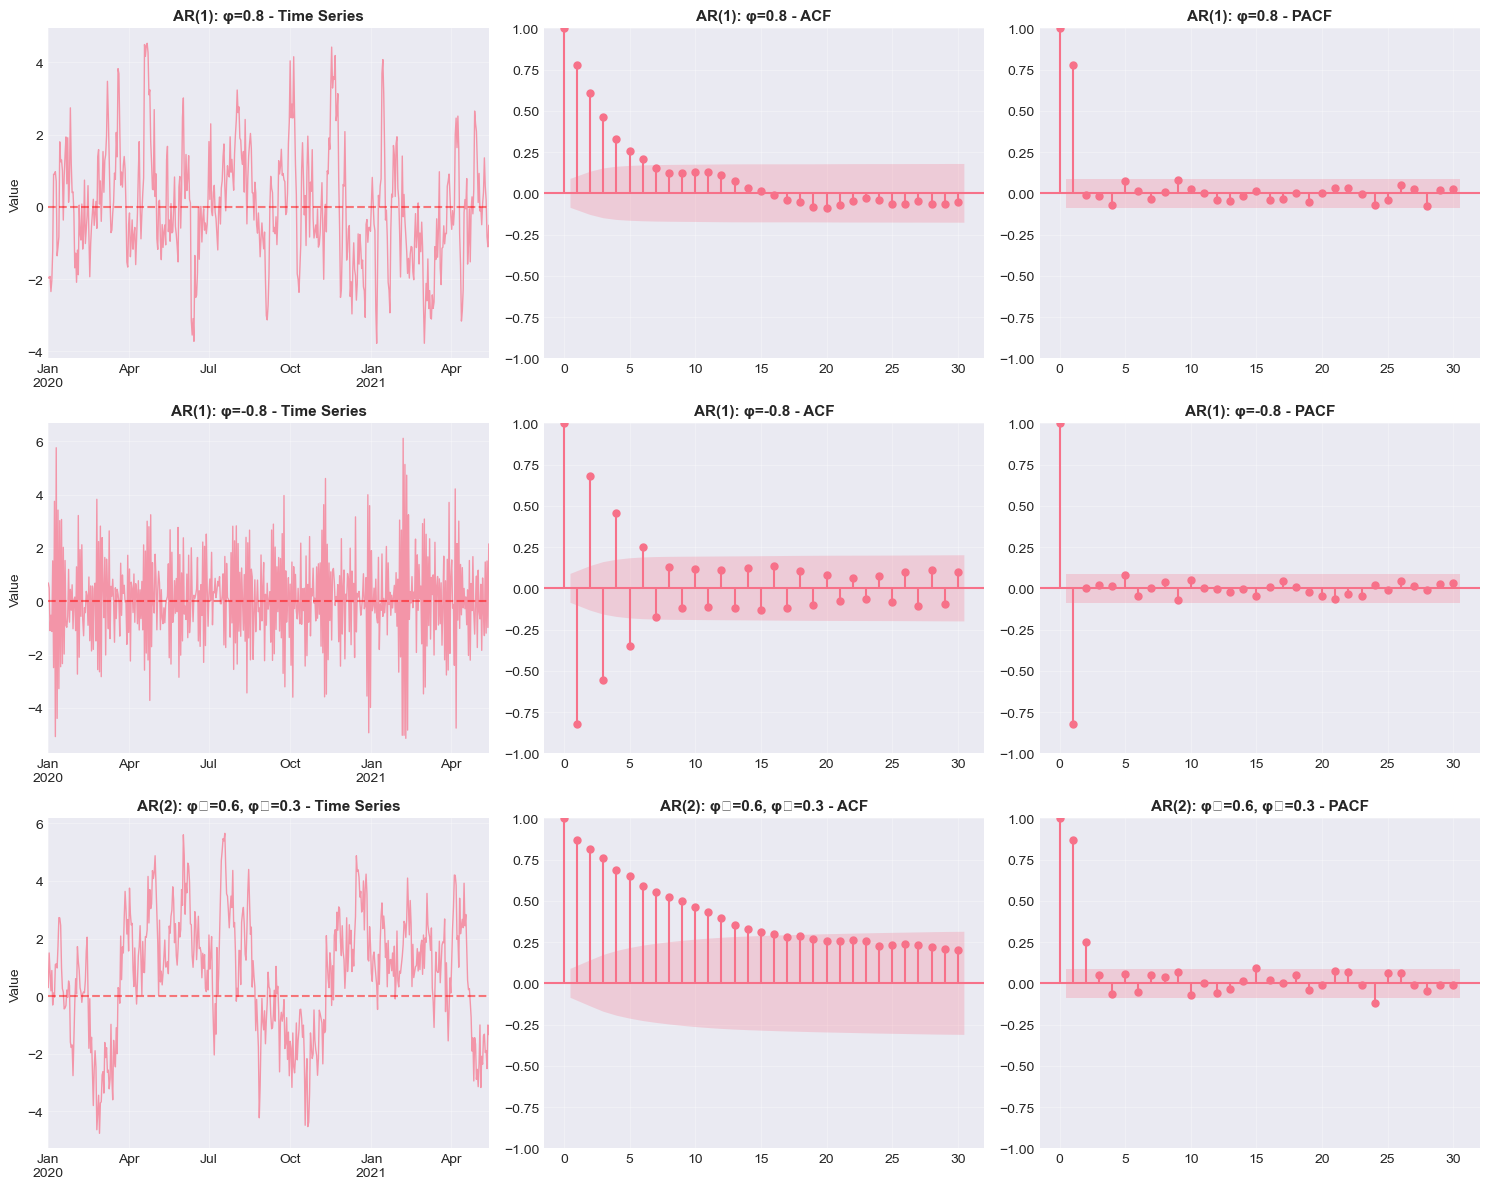


Key Observations:
• AR(1) φ=0.8: Positive autocorrelation, smooth decay in ACF
• AR(1) φ=-0.8: Oscillating pattern, alternating signs in ACF
• AR(2): Complex decay pattern, PACF cuts off after lag 2
• PACF cutoff at lag p is diagnostic of AR(p) process


In [6]:
# Visualize AR processes
fig, axes = plt.subplots(3, 3, figsize=(15, 12))

processes = [
    (ts_ar1_pos, 'AR(1): φ=0.8', 0),
    (ts_ar1_neg, 'AR(1): φ=-0.8', 1),
    (ts_ar2, 'AR(2): φ₁=0.6, φ₂=0.3', 2)
]

for ts, title, row in processes:
    # Time series plot
    ts.plot(ax=axes[row, 0], linewidth=1, alpha=0.7)
    axes[row, 0].axhline(y=0, color='r', linestyle='--', alpha=0.5)
    axes[row, 0].set_title(f'{title} - Time Series', fontsize=11, fontweight='bold')
    axes[row, 0].set_ylabel('Value')
    axes[row, 0].grid(True, alpha=0.3)
    
    # ACF
    plot_acf(ts, lags=30, ax=axes[row, 1], alpha=0.05)
    axes[row, 1].set_title(f'{title} - ACF', fontsize=11, fontweight='bold')
    axes[row, 1].grid(True, alpha=0.3)
    
    # PACF
    plot_pacf(ts, lags=30, ax=axes[row, 2], alpha=0.05, method='ywm')
    axes[row, 2].set_title(f'{title} - PACF', fontsize=11, fontweight='bold')
    axes[row, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nKey Observations:")
print("• AR(1) φ=0.8: Positive autocorrelation, smooth decay in ACF")
print("• AR(1) φ=-0.8: Oscillating pattern, alternating signs in ACF")
print("• AR(2): Complex decay pattern, PACF cuts off after lag 2")
print("• PACF cutoff at lag p is diagnostic of AR(p) process")

## 2. Moving Average (MA) Processes

### 2.1 MA(1) Process

An **MA(1)** process is defined as:

$$y_t = \mu + \epsilon_t + \theta_1 \epsilon_{t-1}$$

where:
- $\mu$ is the mean
- $\theta_1$ is the MA parameter
- $\epsilon_t \sim WN(0, \sigma^2)$

**Properties**:
- Always stationary
- Mean: $E[y_t] = \mu$
- Variance: $\gamma_0 = \sigma^2(1 + \theta_1^2)$
- Autocorrelation: $\rho_1 = \frac{\theta_1}{1+\theta_1^2}$, $\rho_k = 0$ for $k > 1$

**Invertibility condition**: $|\theta_1| < 1$ (for unique representation)

### 2.2 MA(q) Process

The general **MA(q)** process:

$$y_t = \mu + \epsilon_t + \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2} + \cdots + \theta_q \epsilon_{t-q}$$

**Lag operator form**:
$$y_t = \mu + \theta(L)\epsilon_t$$

where $\theta(L) = 1 + \theta_1 L + \theta_2 L^2 + \cdots + \theta_q L^q$

**Invertibility condition**: All roots of $\theta(L) = 0$ must lie outside the unit circle.

### 2.3 ACF and PACF for MA Processes

**Key identification pattern**:
- **ACF**: Cuts off after lag $q$
- **PACF**: Decays exponentially (or with damped oscillations)

This is the **opposite** of AR processes!

In [9]:
def simulate_ma(theta, n=500, mu=0, sigma=1, burnin=100):
    """
    Simulate MA process.
    
    Parameters:
    -----------
    theta : array-like
        MA coefficients [theta_1, theta_2, ..., theta_q]
    n : int
        Number of observations
    mu : float
        Mean
    sigma : float
        Standard deviation of innovations
    burnin : int
        Burn-in period
    
    Returns:
    --------
    y : np.array
        Simulated series
    """
    ar = np.array([1])  # No AR component
    ma = np.r_[1, np.array(theta)]  # [1, theta_1, theta_2, ...]
    
    ma_process = ArmaProcess(ar, ma)
    y = ma_process.generate_sample(nsample=n+burnin, scale=sigma)
    
    return y[burnin:] + mu

# Simulate different MA processes
# MA(1) with positive coefficient
ma1_pos = simulate_ma(theta=[0.8], n=n)

# MA(1) with negative coefficient
ma1_neg = simulate_ma(theta=[-0.8], n=n)

# MA(2) process
ma2 = simulate_ma(theta=[0.6, 0.3], n=n)

# Create time series
ts_ma1_pos = pd.Series(ma1_pos, index=dates, name='MA(1): θ=0.8')
ts_ma1_neg = pd.Series(ma1_neg, index=dates, name='MA(1): θ=-0.8')
ts_ma2 = pd.Series(ma2, index=dates, name='MA(2): θ₁=0.6, θ₂=0.3')

print("\nMA Process Statistics:")
print("="*60)
for ts in [ts_ma1_pos, ts_ma1_neg, ts_ma2]:
    print(f"\n{ts.name}:")
    print(f"  Mean: {ts.mean():.4f}")
    print(f"  Std Dev: {ts.std():.4f}")
    print(f"  Min: {ts.min():.4f}")
    print(f"  Max: {ts.max():.4f}")


MA Process Statistics:

MA(1): θ=0.8:
  Mean: -0.0217
  Std Dev: 1.2591
  Min: -4.0666
  Max: 4.7065

MA(1): θ=-0.8:
  Mean: 0.0038
  Std Dev: 1.2872
  Min: -5.2251
  Max: 3.6094

MA(2): θ₁=0.6, θ₂=0.3:
  Mean: 0.0405
  Std Dev: 1.2308
  Min: -3.3041
  Max: 3.3566


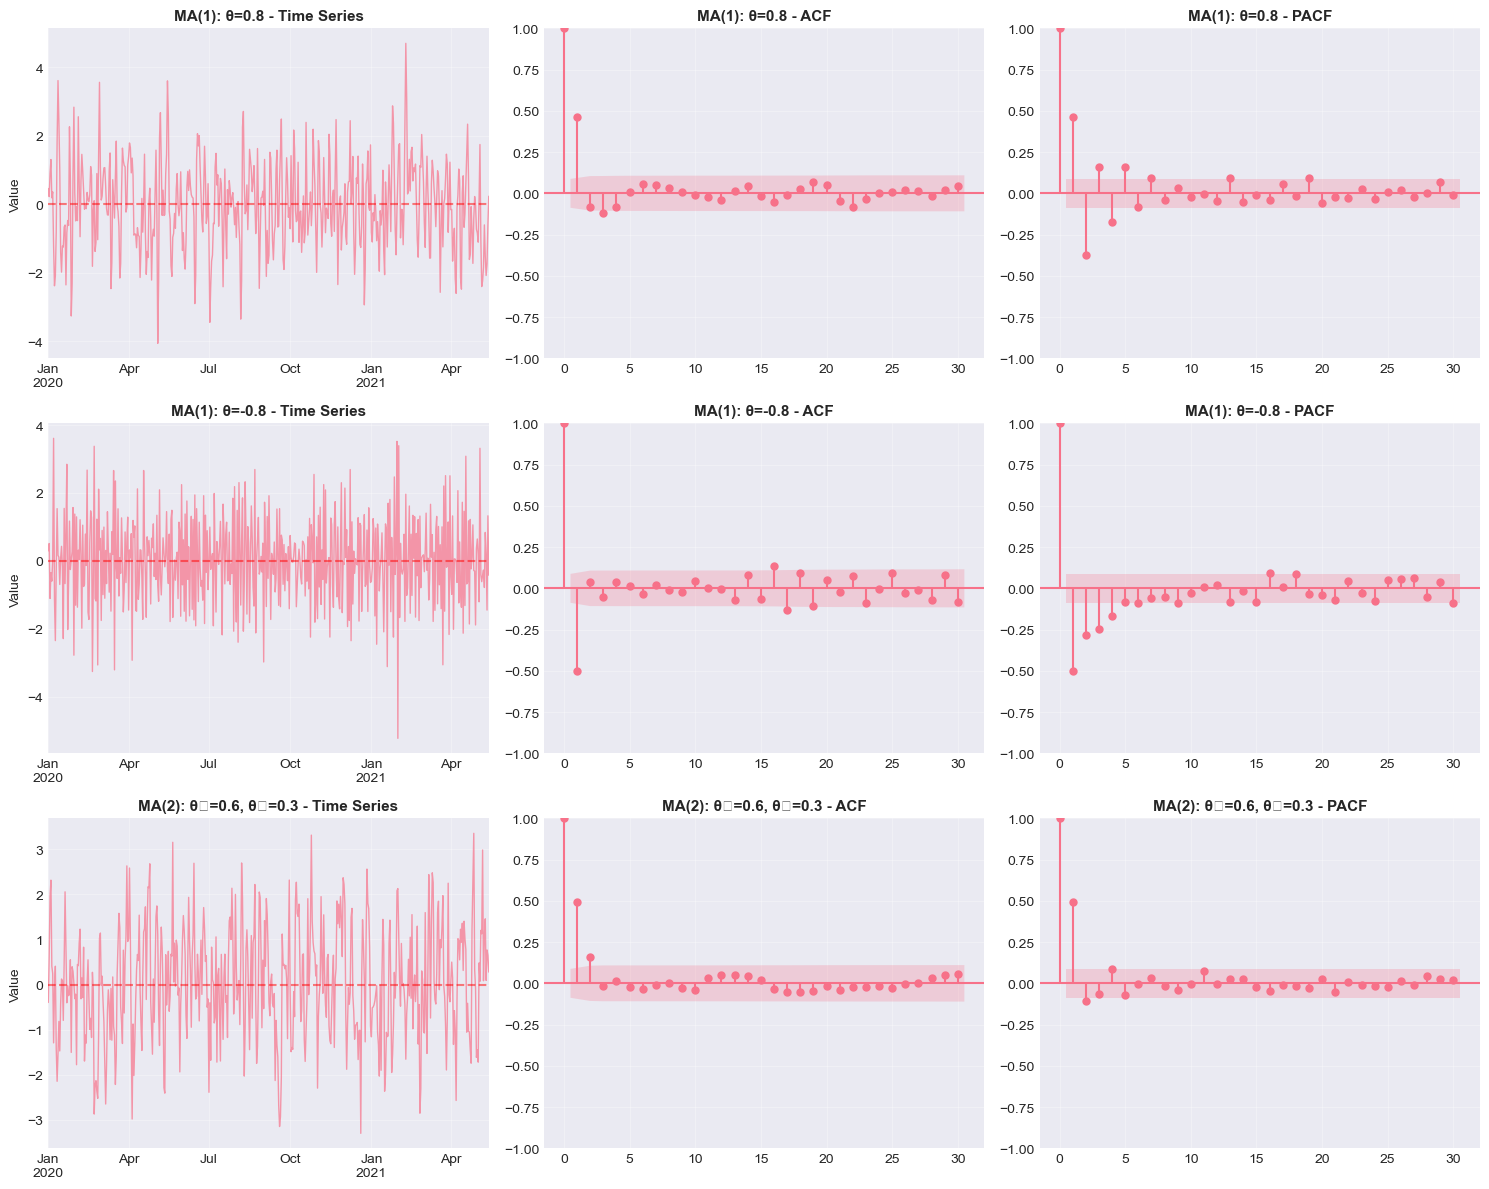


Key Observations:
• MA(1): ACF cuts off after lag 1 (signature pattern)
• MA(1): PACF decays gradually (infinite tail)
• MA(2): ACF cuts off after lag 2
• MA processes are mirror image of AR in ACF/PACF behavior


In [11]:
# Visualize MA processes
fig, axes = plt.subplots(3, 3, figsize=(15, 12))

processes = [
    (ts_ma1_pos, 'MA(1): θ=0.8', 0),
    (ts_ma1_neg, 'MA(1): θ=-0.8', 1),
    (ts_ma2, 'MA(2): θ₁=0.6, θ₂=0.3', 2)
]

for ts, title, row in processes:
    # Time series plot
    ts.plot(ax=axes[row, 0], linewidth=1, alpha=0.7)
    axes[row, 0].axhline(y=0, color='r', linestyle='--', alpha=0.5)
    axes[row, 0].set_title(f'{title} - Time Series', fontsize=11, fontweight='bold')
    axes[row, 0].set_ylabel('Value')
    axes[row, 0].grid(True, alpha=0.3)
    
    # ACF
    plot_acf(ts, lags=30, ax=axes[row, 1], alpha=0.05)
    axes[row, 1].set_title(f'{title} - ACF', fontsize=11, fontweight='bold')
    axes[row, 1].grid(True, alpha=0.3)
    
    # PACF
    plot_pacf(ts, lags=30, ax=axes[row, 2], alpha=0.05, method='ywm')
    axes[row, 2].set_title(f'{title} - PACF', fontsize=11, fontweight='bold')
    axes[row, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nKey Observations:")
print("• MA(1): ACF cuts off after lag 1 (signature pattern)")
print("• MA(1): PACF decays gradually (infinite tail)")
print("• MA(2): ACF cuts off after lag 2")
print("• MA processes are mirror image of AR in ACF/PACF behavior")

## 3. ARMA Processes

### 3.1 ARMA(p,q) Model

An **ARMA(p,q)** process combines AR and MA components:

$$y_t = c + \phi_1 y_{t-1} + \cdots + \phi_p y_{t-p} + \epsilon_t + \theta_1 \epsilon_{t-1} + \cdots + \theta_q \epsilon_{t-q}$$

**Lag operator form**:
$$\phi(L)y_t = c + \theta(L)\epsilon_t$$

**Conditions**:
- Stationarity: Roots of $\phi(L) = 0$ outside unit circle
- Invertibility: Roots of $\theta(L) = 0$ outside unit circle

### 3.2 Why ARMA?

**Parsimony principle**: ARMA models can represent complex processes with fewer parameters.

**Example**: An AR(∞) process can often be approximated by a parsimonious ARMA(p,q) with small p and q.

### 3.3 ACF and PACF for ARMA

**Identification pattern**:
- **ACF**: Decays exponentially (no clear cutoff)
- **PACF**: Decays exponentially (no clear cutoff)

Both tails off gradually, making identification more challenging than pure AR or MA.

In [13]:
def simulate_arma(phi, theta, n=500, c=0, sigma=1, burnin=100):
    """
    Simulate ARMA process.
    """
    ar = np.r_[1, -np.array(phi)] if len(phi) > 0 else np.array([1])
    ma = np.r_[1, np.array(theta)] if len(theta) > 0 else np.array([1])
    
    arma_process = ArmaProcess(ar, ma)
    y = arma_process.generate_sample(nsample=n+burnin, scale=sigma)
    
    if c != 0 and len(phi) > 0:
        mu = c / (1 - np.sum(phi))
        y = y + mu
    
    return y[burnin:]

# Simulate ARMA processes
arma11 = simulate_arma(phi=[0.7], theta=[0.4], n=n)
arma21 = simulate_arma(phi=[0.5, 0.3], theta=[0.6], n=n)

ts_arma11 = pd.Series(arma11, index=dates, name='ARMA(1,1): φ=0.7, θ=0.4')
ts_arma21 = pd.Series(arma21, index=dates, name='ARMA(2,1): φ₁=0.5, φ₂=0.3, θ=0.6')

print("\nARMA Process Statistics:")
print("="*60)
for ts in [ts_arma11, ts_arma21]:
    print(f"\n{ts.name}:")
    print(f"  Mean: {ts.mean():.4f}")
    print(f"  Std Dev: {ts.std():.4f}")


ARMA Process Statistics:

ARMA(1,1): φ=0.7, θ=0.4:
  Mean: -0.3840
  Std Dev: 1.8305

ARMA(2,1): φ₁=0.5, φ₂=0.3, θ=0.6:
  Mean: -0.3725
  Std Dev: 2.0634


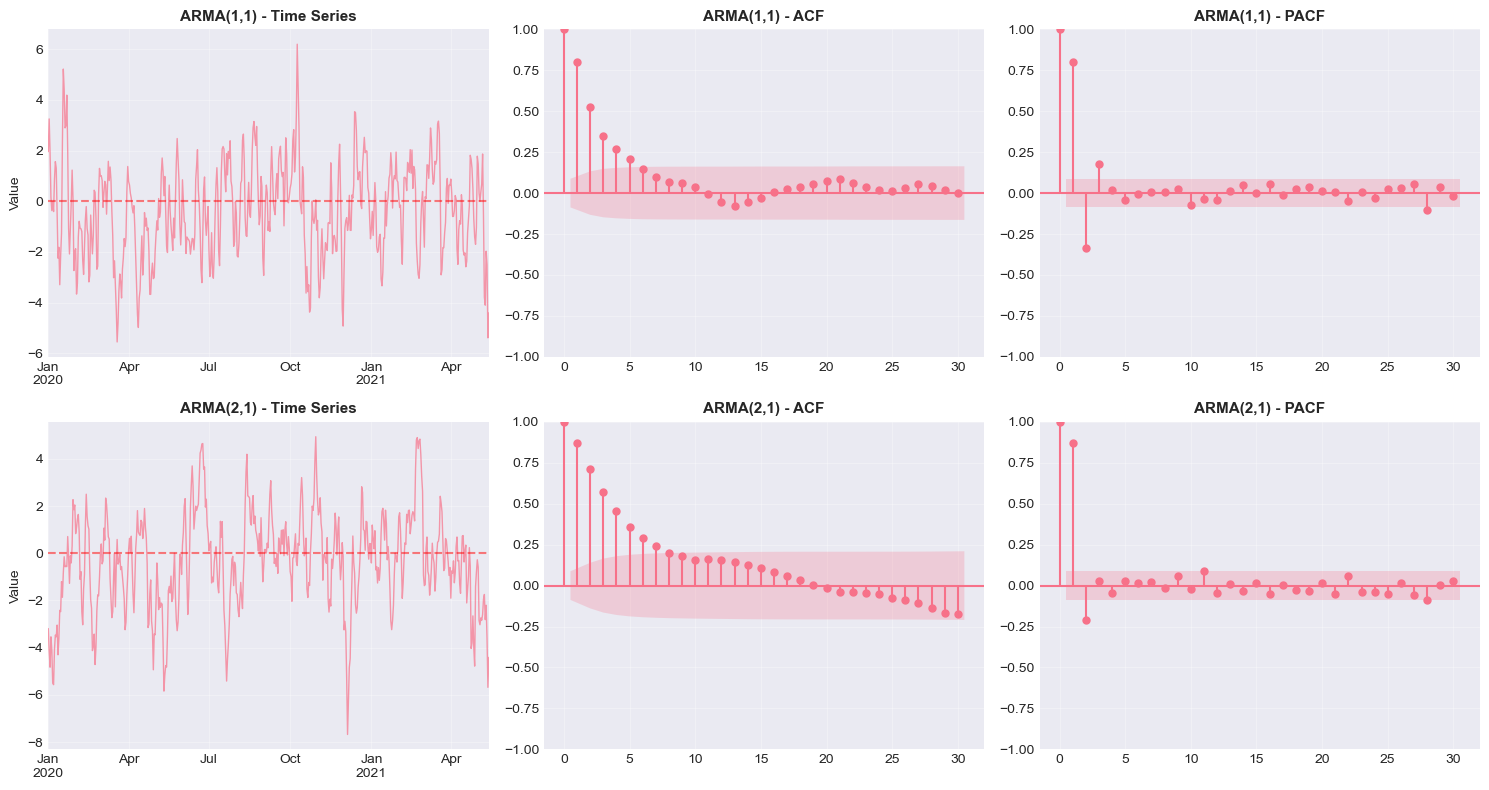


Key Observations:
• ARMA: Both ACF and PACF decay gradually
• No clear cutoff in either ACF or PACF
• Identification requires careful examination of patterns
• Information criteria (AIC/BIC) help select orders


In [15]:
# Visualize ARMA processes
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

processes = [
    (ts_arma11, 'ARMA(1,1)', 0),
    (ts_arma21, 'ARMA(2,1)', 1)
]

for ts, title, row in processes:
    # Time series
    ts.plot(ax=axes[row, 0], linewidth=1, alpha=0.7)
    axes[row, 0].axhline(y=0, color='r', linestyle='--', alpha=0.5)
    axes[row, 0].set_title(f'{title} - Time Series', fontsize=11, fontweight='bold')
    axes[row, 0].set_ylabel('Value')
    axes[row, 0].grid(True, alpha=0.3)
    
    # ACF
    plot_acf(ts, lags=30, ax=axes[row, 1], alpha=0.05)
    axes[row, 1].set_title(f'{title} - ACF', fontsize=11, fontweight='bold')
    axes[row, 1].grid(True, alpha=0.3)
    
    # PACF
    plot_pacf(ts, lags=30, ax=axes[row, 2], alpha=0.05, method='ywm')
    axes[row, 2].set_title(f'{title} - PACF', fontsize=11, fontweight='bold')
    axes[row, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nKey Observations:")
print("• ARMA: Both ACF and PACF decay gradually")
print("• No clear cutoff in either ACF or PACF")
print("• Identification requires careful examination of patterns")
print("• Information criteria (AIC/BIC) help select orders")

## 4. Integrated Processes and ARIMA

### 4.1 Integration and Differencing

A series is **integrated of order d**, denoted **I(d)**, if it becomes stationary after differencing d times.

**First difference**:
$$\Delta y_t = y_t - y_{t-1} = (1-L)y_t$$

**Second difference**:
$$\Delta^2 y_t = \Delta(\Delta y_t) = (1-L)^2 y_t$$

### 4.2 ARIMA(p,d,q) Model

An **ARIMA(p,d,q)** model applies ARMA(p,q) to the d-th difference:

$$\phi(L)(1-L)^d y_t = c + \theta(L)\epsilon_t$$

**Components**:
- **p**: Order of AR component
- **d**: Degree of differencing
- **q**: Order of MA component

**Common cases**:
- **ARIMA(0,1,0)**: Random walk
- **ARIMA(0,1,1)**: Random walk with drift (≡ Simple Exponential Smoothing)
- **ARIMA(1,1,0)**: Differenced AR(1)

### 4.3 Determining d

**Methods**:
1. **Unit root tests**: ADF, KPSS (from Session 1)
2. **Visual inspection**: Look for trend, changing variance
3. **ACF pattern**: Slow decay suggests non-stationarity

**Guidelines**:
- Most economic/financial series: $d \in \{0, 1, 2\}$
- $d > 2$ is rare in practice
- Over-differencing can introduce spurious autocorrelation

In [18]:
# Demonstrate differencing
# Generate random walk with drift
np.random.seed(42)
drift = 0.1
innovations = np.random.normal(drift, 1, n)
random_walk = np.cumsum(innovations)

ts_rw = pd.Series(random_walk, index=dates, name='Random Walk')
ts_rw_diff = ts_rw.diff().dropna()

# Test for unit root before and after differencing
def test_stationarity_simple(series, name):
    """
    Quick stationarity test.
    """
    adf_result = adfuller(series, autolag='AIC')
    
    print(f"\n{name}:")
    print("-" * 60)
    print(f"ADF Statistic: {adf_result[0]:.4f}")
    print(f"P-value: {adf_result[1]:.4f}")
    print(f"Critical Values:")
    for key, value in adf_result[4].items():
        print(f"  {key}: {value:.4f}")
    
    if adf_result[1] < 0.05:
        print("✓ Reject H0: Series is STATIONARY")
    else:
        print("✗ Fail to reject H0: Series is NON-STATIONARY")
    
    return adf_result[1] < 0.05

print("\nStationarity Testing:")
print("="*60)
is_stat_orig = test_stationarity_simple(ts_rw, "Original Series (Random Walk)")
is_stat_diff = test_stationarity_simple(ts_rw_diff, "First Difference")


Stationarity Testing:

Original Series (Random Walk):
------------------------------------------------------------
ADF Statistic: -0.1427
P-value: 0.9450
Critical Values:
  1%: -3.4435
  5%: -2.8673
  10%: -2.5699
✗ Fail to reject H0: Series is NON-STATIONARY

First Difference:
------------------------------------------------------------
ADF Statistic: -22.3130
P-value: 0.0000
Critical Values:
  1%: -3.4435
  5%: -2.8674
  10%: -2.5699
✓ Reject H0: Series is STATIONARY


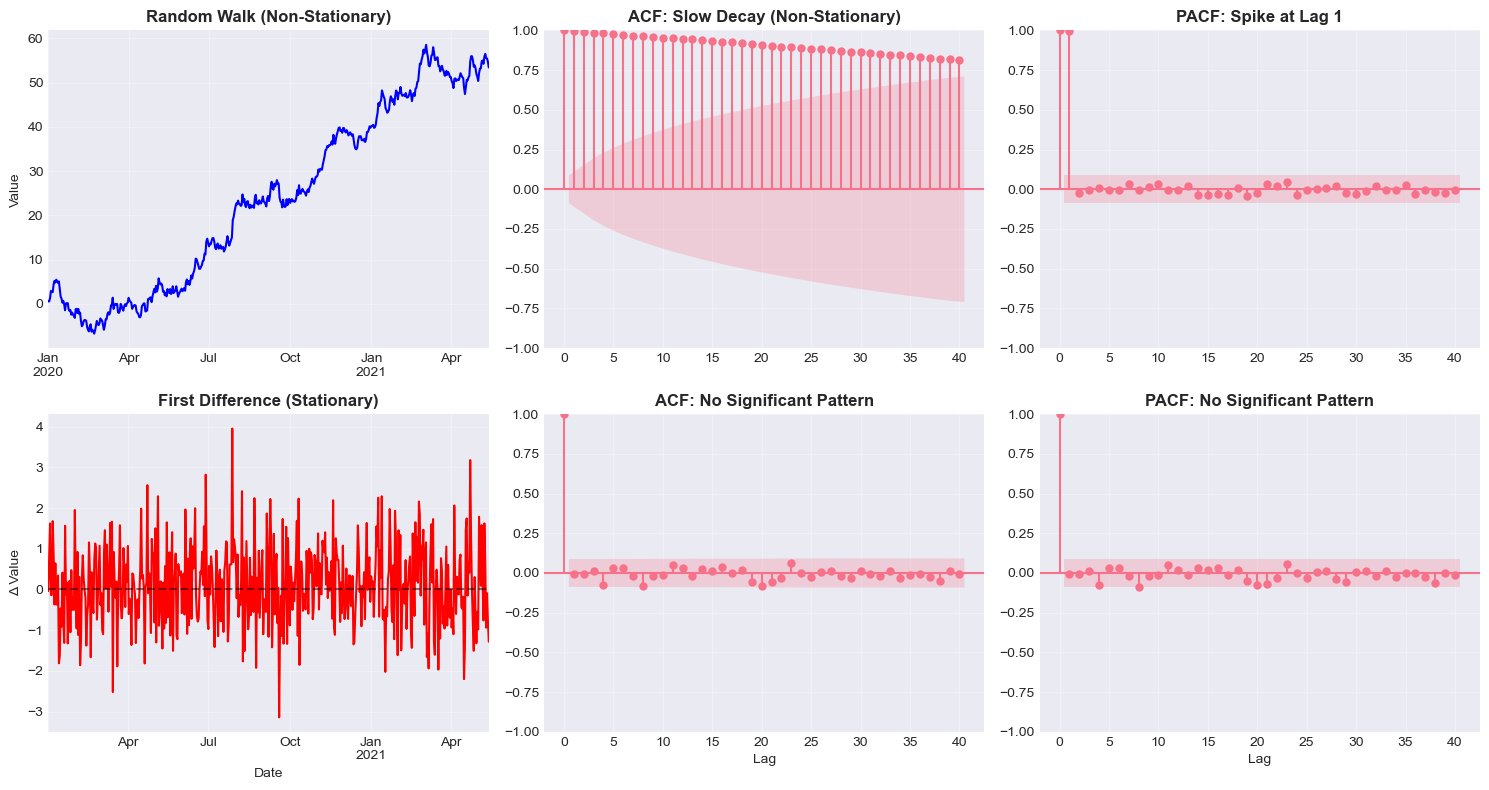


Differencing Interpretation:
• Original: Clear trend, ACF decays very slowly → Non-stationary
• Differenced: Mean-reverting, ACF/PACF insignificant → Stationary
• This is I(1) process: stationary after 1st difference
• Appropriate model: ARIMA(0,1,0) or similar


In [20]:
# Visualize differencing
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# Original series
ts_rw.plot(ax=axes[0, 0], linewidth=1.5, color='blue')
axes[0, 0].set_title('Random Walk (Non-Stationary)', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Value')
axes[0, 0].grid(True, alpha=0.3)

plot_acf(ts_rw, lags=40, ax=axes[0, 1], alpha=0.05)
axes[0, 1].set_title('ACF: Slow Decay (Non-Stationary)', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

plot_pacf(ts_rw, lags=40, ax=axes[0, 2], alpha=0.05, method='ywm')
axes[0, 2].set_title('PACF: Spike at Lag 1', fontsize=12, fontweight='bold')
axes[0, 2].grid(True, alpha=0.3)

# Differenced series
ts_rw_diff.plot(ax=axes[1, 0], linewidth=1.5, color='red')
axes[1, 0].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[1, 0].set_title('First Difference (Stationary)', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Date')
axes[1, 0].set_ylabel('Δ Value')
axes[1, 0].grid(True, alpha=0.3)

plot_acf(ts_rw_diff, lags=40, ax=axes[1, 1], alpha=0.05)
axes[1, 1].set_title('ACF: No Significant Pattern', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Lag')
axes[1, 1].grid(True, alpha=0.3)

plot_pacf(ts_rw_diff, lags=40, ax=axes[1, 2], alpha=0.05, method='ywm')
axes[1, 2].set_title('PACF: No Significant Pattern', fontsize=12, fontweight='bold')
axes[1, 2].set_xlabel('Lag')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nDifferencing Interpretation:")
print("• Original: Clear trend, ACF decays very slowly → Non-stationary")
print("• Differenced: Mean-reverting, ACF/PACF insignificant → Stationary")
print("• This is I(1) process: stationary after 1st difference")
print("• Appropriate model: ARIMA(0,1,0) or similar")

## 5. Box-Jenkins Methodology

### 5.1 The Box-Jenkins Approach

A systematic procedure for ARIMA modeling:

**Step 1: Identification**
- Plot the data
- Test for stationarity (determine d)
- Examine ACF and PACF (determine p and q)
- Propose candidate models

**Step 2: Estimation**
- Estimate parameters using Maximum Likelihood
- Check parameter significance
- Calculate standard errors

**Step 3: Diagnostic Checking**
- Examine residuals for white noise
- Check residual ACF/PACF
- Perform Ljung-Box test
- Check normality of residuals

**Step 4: Forecasting**
- Generate point forecasts
- Calculate prediction intervals
- Evaluate forecast accuracy

If diagnostics fail, return to Step 1 and try alternative specifications.

### 5.2 Model Identification Table

| Process | ACF | PACF |
|---------|-----|------|
| AR(p) | Decays | Cuts off after lag p |
| MA(q) | Cuts off after lag q | Decays |
| ARMA(p,q) | Decays | Decays |
| Non-stationary | Slow decay | Spike at lag 1 |

### 5.3 Information Criteria for Model Selection

When multiple models seem plausible:

**AIC**: $AIC = -2\log(L) + 2k$

**BIC**: $BIC = -2\log(L) + k\log(n)$

**AICc**: $AIC_c = AIC + \frac{2k(k+1)}{n-k-1}$

Select model with **minimum** criterion value.

In [25]:
# Download real financial data
print("Downloading stock market data...")

ticker = '^GSPC'  # S&P 500
data = yf.download(ticker, start='2018-01-01', end='2024-01-01', progress=False)
prices = data['Close'].dropna()
returns = prices.pct_change().dropna() * 100  # Percentage returns

print(f"\nData: {ticker}")
print(f"Period: {prices.index[0].date()} to {prices.index[-1].date()}")
print(f"Observations: {len(prices)}")

# Split data
train_size = int(len(returns) * 0.9)
returns_train = returns[:train_size]
returns_test = returns[train_size:]

print(f"\nTraining size: {len(returns_train)}")
print(f"Test size: {len(returns_test)}")


Data: ^GSPC
Period: 2018-01-02 to 2023-12-29
Observations: 1509

Training size: 1357
Test size: 151



STEP 1: IDENTIFICATION


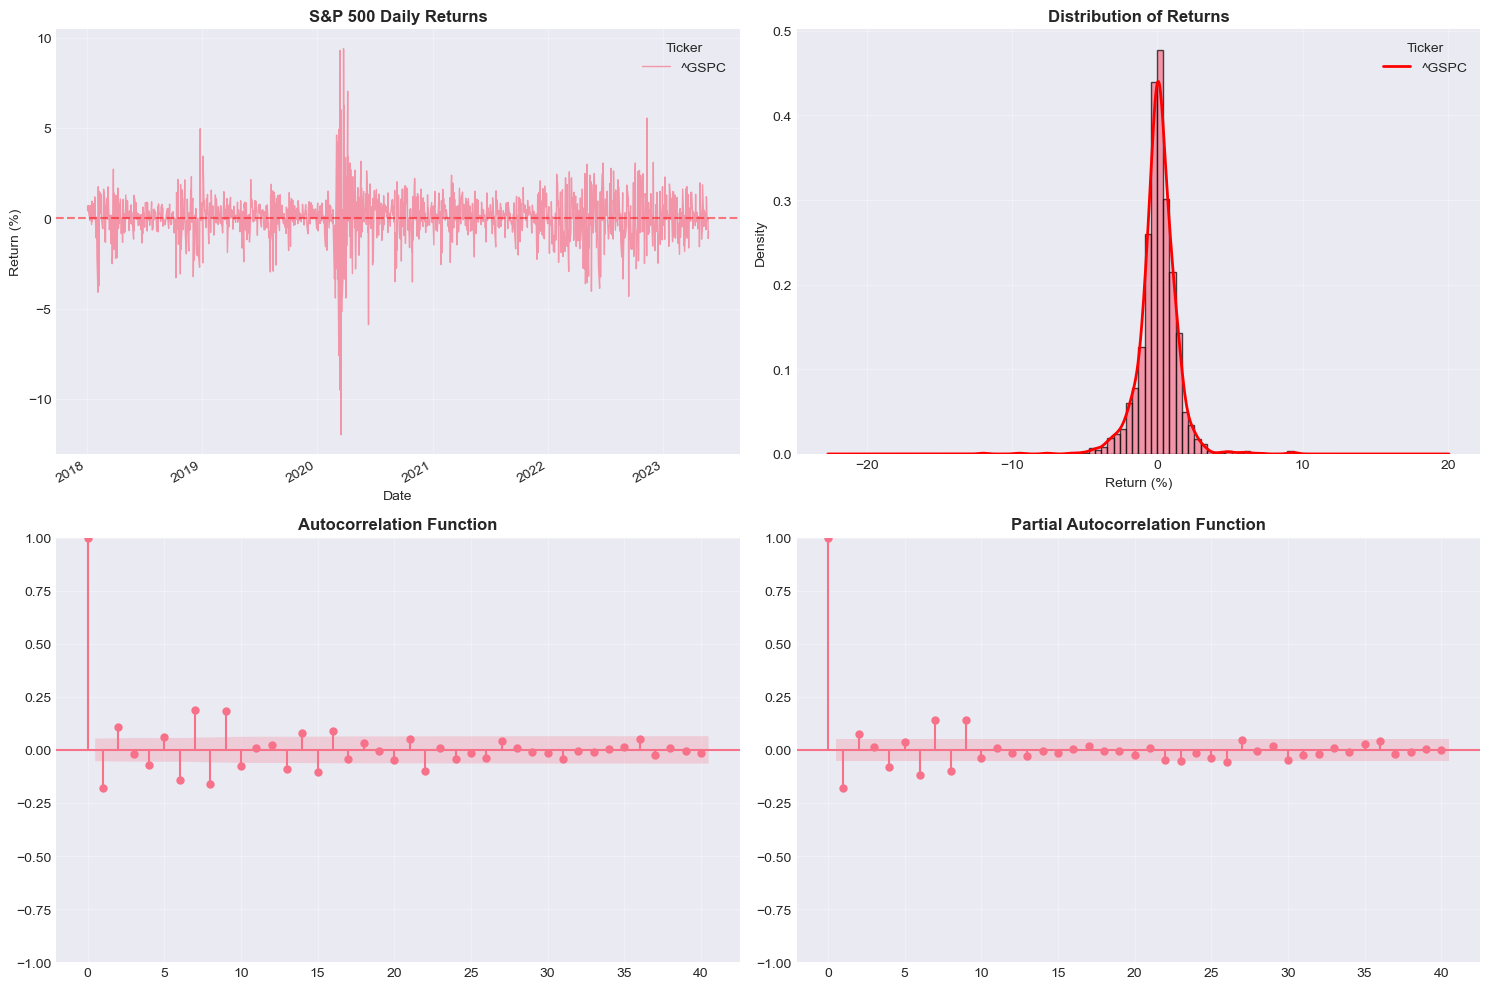


Returns Series:
------------------------------------------------------------
ADF Statistic: -11.3231
P-value: 0.0000
Critical Values:
  1%: -3.4352
  5%: -2.8637
  10%: -2.5679
✓ Reject H0: Series is STATIONARY

Descriptive Statistics:
------------------------------------------------------------
Mean: 0.0403%
Std Dev: 1.3511%
Skewness: -0.4927
Kurtosis: 12.0656

Initial Assessment:
• Returns appear stationary (mean-reverting around 0)
• Some significant autocorrelation at early lags
• Distribution shows fat tails (excess kurtosis)
• Candidate models: ARMA(p,q) with small p, q


In [29]:
# Step 1: Identification
print("\n" + "="*60)
print("STEP 1: IDENTIFICATION")
print("="*60)

# Plot data
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Returns time series
returns_train.plot(ax=axes[0, 0], linewidth=1, alpha=0.7)
axes[0, 0].axhline(y=0, color='r', linestyle='--', alpha=0.5)
axes[0, 0].set_title('S&P 500 Daily Returns', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Return (%)')
axes[0, 0].grid(True, alpha=0.3)

# Distribution
returns_train.hist(ax=axes[0, 1], bins=50, density=True, alpha=0.7, edgecolor='black')
returns_train.plot.kde(ax=axes[0, 1], color='red', linewidth=2)
axes[0, 1].set_title('Distribution of Returns', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Return (%)')
axes[0, 1].grid(True, alpha=0.3)

# ACF
plot_acf(returns_train, lags=40, ax=axes[1, 0], alpha=0.05)
axes[1, 0].set_title('Autocorrelation Function', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# PACF
plot_pacf(returns_train, lags=40, ax=axes[1, 1], alpha=0.05, method='ywm')
axes[1, 1].set_title('Partial Autocorrelation Function', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Stationarity test
test_stationarity_simple(returns_train, "Returns Series")
returns_train = returns_train['^GSPC']

# Descriptive statistics
print("\nDescriptive Statistics:")
print("-" * 60)
print(f"Mean: {returns_train.mean():.4f}%")
print(f"Std Dev: {returns_train.std():.4f}%")
print(f"Skewness: {returns_train.skew():.4f}")
print(f"Kurtosis: {returns_train.kurtosis():.4f}")

print("\nInitial Assessment:")
print("• Returns appear stationary (mean-reverting around 0)")
print("• Some significant autocorrelation at early lags")
print("• Distribution shows fat tails (excess kurtosis)")
print("• Candidate models: ARMA(p,q) with small p, q")

In [31]:
# Step 2: Estimation - Try multiple models
print("\n" + "="*60)
print("STEP 2: ESTIMATION")
print("="*60)

# Define candidate models
candidate_models = [
    (0, 0, 0),  # White noise (baseline)
    (1, 0, 0),  # AR(1)
    (2, 0, 0),  # AR(2)
    (0, 0, 1),  # MA(1)
    (0, 0, 2),  # MA(2)
    (1, 0, 1),  # ARMA(1,1)
    (2, 0, 1),  # ARMA(2,1)
    (1, 0, 2),  # ARMA(1,2)
]

results = []

for order in candidate_models:
    try:
        model = ARIMA(returns_train, order=order)
        fitted = model.fit()
        
        results.append({
            'Model': f'ARIMA{order}',
            'AIC': fitted.aic,
            'BIC': fitted.bic,
            'Log-Likelihood': fitted.llf,
            'Params': len(fitted.params),
            'fitted_model': fitted
        })
    except:
        continue

# Create results dataframe
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('AIC')

print("\nModel Comparison (sorted by AIC):")
print(results_df[['Model', 'AIC', 'BIC', 'Log-Likelihood', 'Params']].to_string(index=False))

# Select best model
best_model = results_df.iloc[0]['fitted_model']
best_order = results_df.iloc[0]['Model']

print(f"\n✓ Best Model: {best_order}")
print(f"  AIC: {results_df.iloc[0]['AIC']:.2f}")
print(f"  BIC: {results_df.iloc[0]['BIC']:.2f}")


STEP 2: ESTIMATION

Model Comparison (sorted by AIC):
         Model       AIC       BIC  Log-Likelihood  Params
ARIMA(0, 0, 2) 4622.8343 4643.6864      -2307.4171       4
ARIMA(2, 0, 0) 4623.1700 4644.0221      -2307.5850       4
ARIMA(1, 0, 2) 4623.7013 4649.7664      -2306.8506       5
ARIMA(2, 0, 1) 4625.0851 4651.1503      -2307.5425       5
ARIMA(1, 0, 1) 4625.9102 4646.7623      -2308.9551       4
ARIMA(1, 0, 0) 4629.1499 4644.7890      -2311.5749       3
ARIMA(0, 0, 1) 4635.7656 4651.4047      -2314.8828       3
ARIMA(0, 0, 0) 4670.6793 4681.1054      -2333.3397       2

✓ Best Model: ARIMA(0, 0, 2)
  AIC: 4622.83
  BIC: 4643.69


In [33]:
# Display detailed results for best model
print("\n" + "="*60)
print(f"Detailed Results: {best_order}")
print("="*60)
print(best_model.summary())


Detailed Results: ARIMA(0, 0, 2)
                               SARIMAX Results                                
Dep. Variable:                  ^GSPC   No. Observations:                 1357
Model:                 ARIMA(0, 0, 2)   Log Likelihood               -2307.417
Date:                Fri, 16 Jan 2026   AIC                           4622.834
Time:                        22:09:39   BIC                           4643.686
Sample:                             0   HQIC                          4630.641
                               - 1357                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0403      0.036      1.105      0.269      -0.031       0.112
ma.L1         -0.1589      0.013    -12.434      0.000      -0.184      -0.134
ma.L2          0.1


STEP 3: DIAGNOSTIC CHECKING


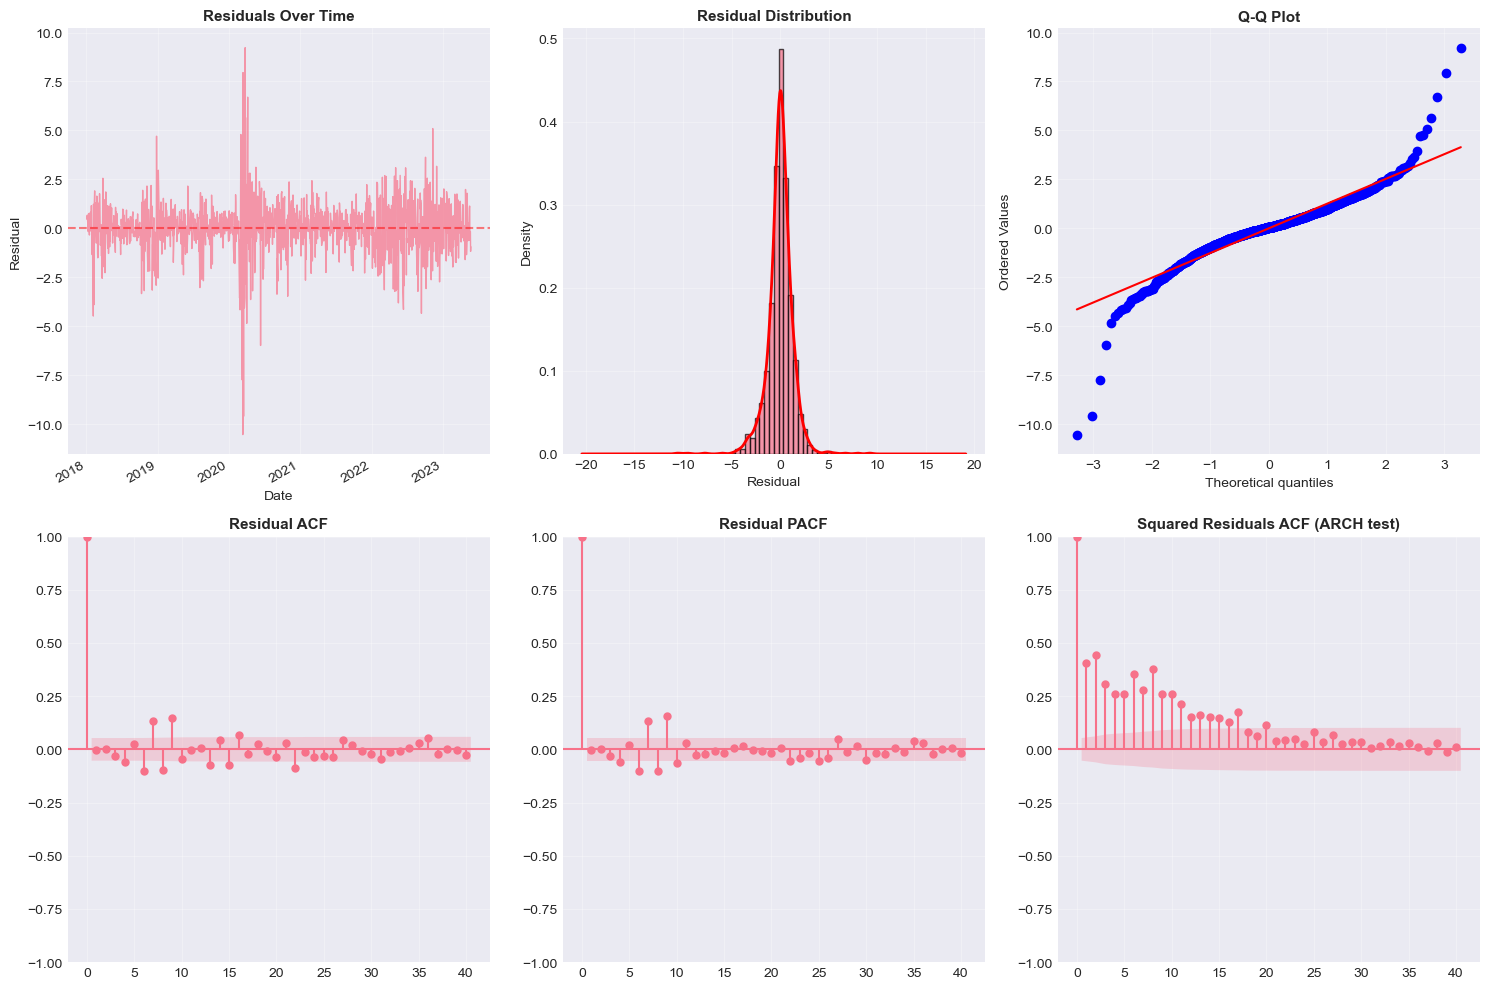


Ljung-Box Test for Residual Autocorrelation:
------------------------------------------------------------
     lb_stat   lb_pvalue
10   90.8356  3.6565e-15
20  118.1060  6.3876e-16
30  139.3673  4.9628e-16

Jarque-Bera Normality Test:
------------------------------------------------------------
Statistic: 5198.3167
P-value: 0.0000
✗ Reject normality (common for financial returns)

ARCH Effects Test (Ljung-Box on Squared Residuals):
------------------------------------------------------------
Q(10): 1456.5043
P-value: 0.0000
✓ Evidence of ARCH effects (volatility clustering)
  → Consider GARCH models (Sessions 6-7)


In [35]:
# Step 3: Diagnostic Checking
print("\n" + "="*60)
print("STEP 3: DIAGNOSTIC CHECKING")
print("="*60)

# Get residuals
residuals = best_model.resid

# Plot diagnostics
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Residuals over time
residuals.plot(ax=axes[0, 0], linewidth=1, alpha=0.7)
axes[0, 0].axhline(y=0, color='r', linestyle='--', alpha=0.5)
axes[0, 0].set_title('Residuals Over Time', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Residual')
axes[0, 0].grid(True, alpha=0.3)

# Residual histogram
residuals.hist(ax=axes[0, 1], bins=40, density=True, alpha=0.7, edgecolor='black')
residuals.plot.kde(ax=axes[0, 1], color='red', linewidth=2)
axes[0, 1].set_title('Residual Distribution', fontsize=11, fontweight='bold')
axes[0, 1].set_xlabel('Residual')
axes[0, 1].grid(True, alpha=0.3)

# Q-Q plot
stats.probplot(residuals, dist="norm", plot=axes[0, 2])
axes[0, 2].set_title('Q-Q Plot', fontsize=11, fontweight='bold')
axes[0, 2].grid(True, alpha=0.3)

# Residual ACF
plot_acf(residuals, lags=40, ax=axes[1, 0], alpha=0.05)
axes[1, 0].set_title('Residual ACF', fontsize=11, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Residual PACF
plot_pacf(residuals, lags=40, ax=axes[1, 1], alpha=0.05, method='ywm')
axes[1, 1].set_title('Residual PACF', fontsize=11, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

# Squared residuals (for ARCH effects)
plot_acf(residuals**2, lags=40, ax=axes[1, 2], alpha=0.05)
axes[1, 2].set_title('Squared Residuals ACF (ARCH test)', fontsize=11, fontweight='bold')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Ljung-Box test
lb_test = acorr_ljungbox(residuals, lags=[10, 20, 30], return_df=True)
print("\nLjung-Box Test for Residual Autocorrelation:")
print("-" * 60)
print(lb_test)

# Normality test
jb_stat, jb_pval = stats.jarque_bera(residuals)
print("\nJarque-Bera Normality Test:")
print("-" * 60)
print(f"Statistic: {jb_stat:.4f}")
print(f"P-value: {jb_pval:.4f}")
if jb_pval < 0.05:
    print("✗ Reject normality (common for financial returns)")
else:
    print("✓ Cannot reject normality")

# ARCH test (check squared residuals)
lb_squared = acorr_ljungbox(residuals**2, lags=[10], return_df=True)
print("\nARCH Effects Test (Ljung-Box on Squared Residuals):")
print("-" * 60)
print(f"Q(10): {lb_squared['lb_stat'].values[0]:.4f}")
print(f"P-value: {lb_squared['lb_pvalue'].values[0]:.4f}")
if lb_squared['lb_pvalue'].values[0] < 0.05:
    print("✓ Evidence of ARCH effects (volatility clustering)")
    print("  → Consider GARCH models (Sessions 6-7)")
else:
    print("✗ No strong evidence of ARCH effects")

In [51]:
forecast.index

RangeIndex(start=1357, stop=1508, step=1)


STEP 4: FORECASTING

Forecast Accuracy Metrics:
------------------------------------------------------------
MAE:  0.5751%
RMSE: 0.7296%
MAPE: 123.92%


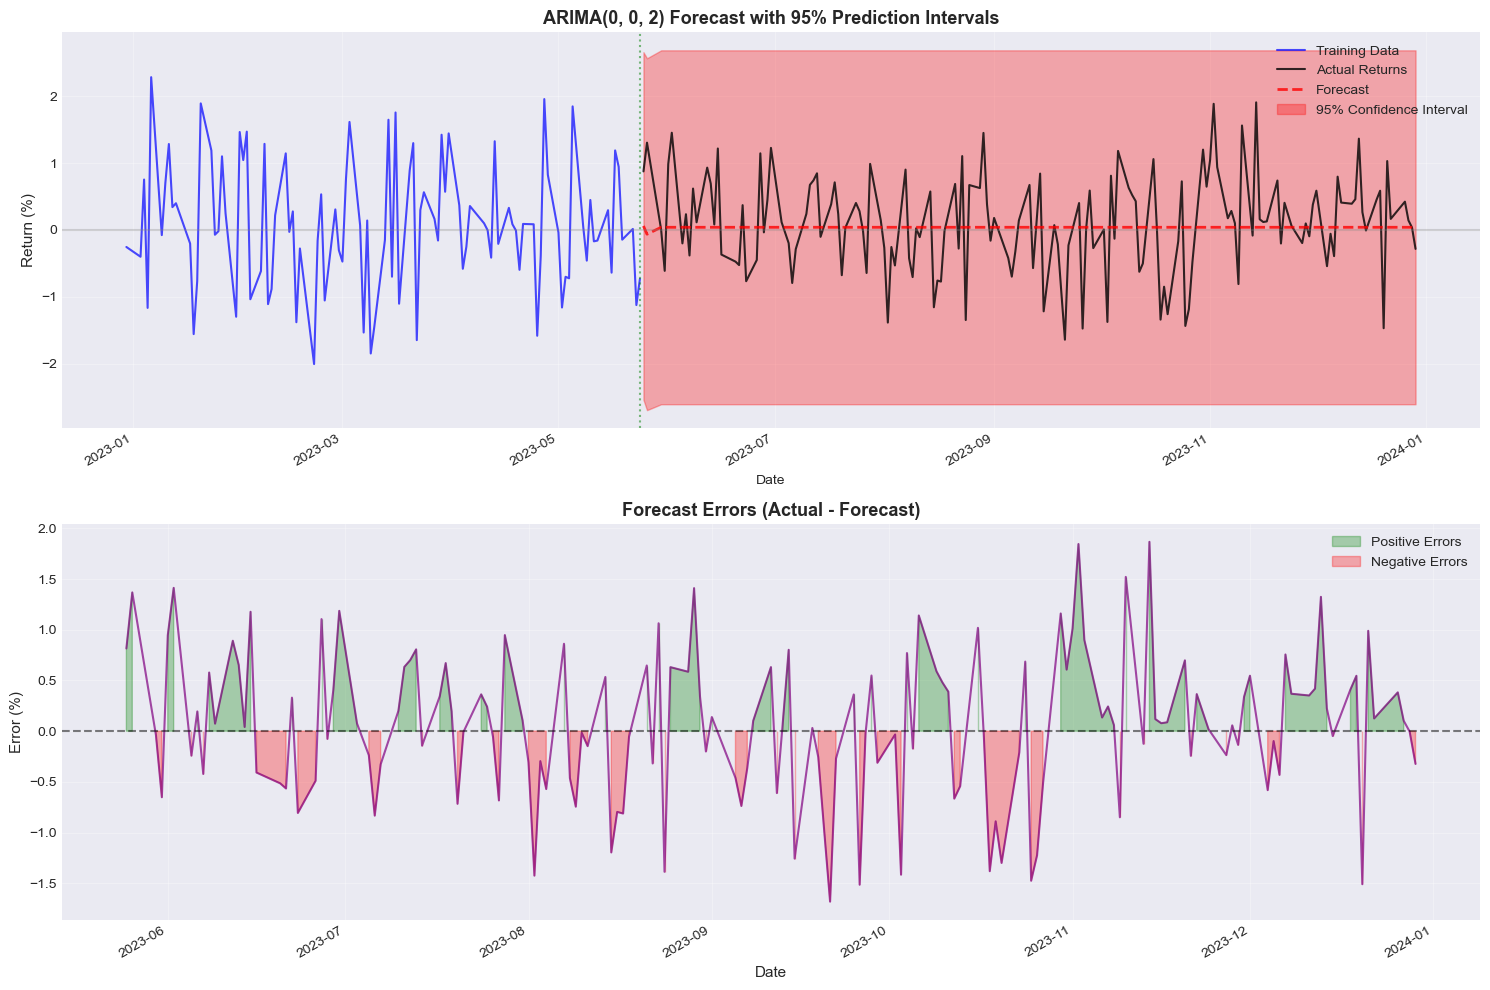


Forecast Evaluation:
• Forecast captures mean tendency but not volatility
• Prediction intervals widen over forecast horizon
• ARIMA captures conditional mean, not variance dynamics
• For volatility forecasting, use GARCH models


In [55]:
# Step 4: Forecasting
print("\n" + "="*60)
print("STEP 4: FORECASTING")
print("="*60)

# Generate forecasts
forecast_steps = len(returns_test)
forecast = best_model.forecast(steps=forecast_steps)
forecast_df = best_model.get_forecast(steps=forecast_steps)
forecast_ci = forecast_df.conf_int()

forecast.index = returns_test.index
forecast_df.index = returns_test.index
forecast_ci.index = returns_test.index

#returns_test = returns_test['^GSPC']
# Calculate forecast errors
mae = np.abs(returns_test - forecast).mean()
rmse = np.sqrt(((returns_test - forecast) ** 2).mean())
mape = (np.abs((returns_test.values - forecast) / returns_test.values) * 100).mean()

print("\nForecast Accuracy Metrics:")
print("-" * 60)
print(f"MAE:  {mae:.4f}%")
print(f"RMSE: {rmse:.4f}%")
print(f"MAPE: {mape:.2f}%")

# Plot forecasts
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Full forecast period
returns_train.iloc[-100:].plot(ax=axes[0], linewidth=1.5, label='Training Data', color='blue', alpha=0.7)
returns_test.plot(ax=axes[0], linewidth=1.5, label='Actual Returns', color='black', alpha=0.8)
forecast.plot(ax=axes[0], linewidth=2, label='Forecast', color='red', style='--', alpha=0.8)
axes[0].fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], 
                     alpha=0.3, color='red', label='95% Confidence Interval')
axes[0].axhline(y=0, color='gray', linestyle='-', alpha=0.3)
axes[0].axvline(x=returns_train.index[-1], color='green', linestyle=':', alpha=0.5)

axes[0].set_title(f'{best_order} Forecast with 95% Prediction Intervals', fontsize=13, fontweight='bold')
axes[0].set_ylabel('Return (%)', fontsize=11)
axes[0].legend(loc='best', fontsize=10)
axes[0].grid(True, alpha=0.3)

# Forecast errors
errors = returns_test - forecast
errors.plot(ax=axes[1], linewidth=1.5, color='purple', alpha=0.7)
axes[1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[1].fill_between(errors.index, 0, errors, where=(errors > 0), 
                     color='green', alpha=0.3, label='Positive Errors')
axes[1].fill_between(errors.index, 0, errors, where=(errors <= 0), 
                     color='red', alpha=0.3, label='Negative Errors')

axes[1].set_title('Forecast Errors (Actual - Forecast)', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Date', fontsize=11)
axes[1].set_ylabel('Error (%)', fontsize=11)
axes[1].legend(loc='best', fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nForecast Evaluation:")
print("• Forecast captures mean tendency but not volatility")
print("• Prediction intervals widen over forecast horizon")
print("• ARIMA captures conditional mean, not variance dynamics")
print("• For volatility forecasting, use GARCH models")

## 6. Practical Guidelines and Common Pitfalls

### 6.1 Model Selection Guidelines

**Start simple**:
1. Begin with low-order models (p, q ≤ 2)
2. Use information criteria for comparison
3. Check residual diagnostics carefully
4. Don't over-fit (parsimony principle)

**When in doubt**:
- AR(1) or MA(1) often adequate for returns
- ARIMA(0,1,1) common for prices (≡ exponential smoothing)
- Use AIC for prediction, BIC for interpretation

### 6.2 Common Pitfalls

**1. Over-differencing**
- Taking too many differences
- Introduces spurious autocorrelation
- Test stationarity after each difference

**2. Ignoring structural breaks**
- Parameter instability over time
- ARIMA assumes constant parameters
- Consider regime-switching models

**3. Neglecting seasonality**
- Seasonal patterns need seasonal ARIMA
- Regular ARIMA will show poor fit
- Use SARIMA (Session 5)

**4. Assuming normality**
- Financial returns have fat tails
- Standard intervals may be too narrow
- Consider robust methods or simulation

**5. Forgetting about ARCH**
- Volatility clustering common in finance
- ARIMA models conditional mean only
- Check for ARCH effects in diagnostics

### 6.3 ARIMA for Financial Returns

**Stylized facts**:
- Returns are approximately stationary (d=0)
- Low autocorrelation in returns
- Strong autocorrelation in squared returns (volatility)
- Fat-tailed distributions

**Implications**:
- Simple models often sufficient: AR(1), MA(1), ARMA(1,1)
- ARIMA captures mean dynamics
- Combine with GARCH for variance dynamics
- Returns harder to forecast than volatility

## 7. Summary

### 7.1 Key Takeaways

**AR, MA, and ARMA Processes**:
- AR: Past values predict future (memory in levels)
- MA: Past shocks predict future (memory in errors)
- ARMA: Combines both for parsimony

**Identification**:
- ACF/PACF patterns reveal model structure
- AR: PACF cuts off, ACF decays
- MA: ACF cuts off, PACF decays
- ARMA: Both decay

**Box-Jenkins Methodology**:
1. Identify: Choose model orders
2. Estimate: Fit parameters
3. Diagnose: Check residuals
4. Forecast: Generate predictions

**ARIMA Models**:
- Handle non-stationary data via differencing
- ARIMA(p,d,q) = ARMA(p,q) on d-th difference
- Most series need d ∈ {0, 1, 2}

**Financial Applications**:
- Returns: Low-order ARMA usually sufficient
- Prices: ARIMA(0,1,1) ≡ exponential smoothing
- Check for ARCH effects
- Combine with GARCH for complete model

### 7.2 Model Selection Checklist

✓ Plot the data and check for trends

✓ Test for stationarity (ADF, KPSS)

✓ Difference if needed and retest

✓ Examine ACF/PACF of stationary series

✓ Fit candidate models (start simple)

✓ Compare using AIC/BIC

✓ Check residuals for white noise

✓ Test for ARCH effects

✓ Validate with out-of-sample forecasts

✓ Consider economic interpretation

### 7.3 Next Session Preview

In **Session 5**, we will cover:
- Seasonal ARIMA (SARIMA) models
- Advanced model selection techniques
- Automatic ARIMA with auto.arima approach
- Long-horizon forecasting
- Model diagnostics in depth

## 8. Exercises

### Exercise 1: Simulated Data
Simulate the following processes (n=500 each):
1. AR(2): $y_t = 0.5y_{t-1} + 0.3y_{t-2} + \epsilon_t$
2. MA(2): $y_t = \epsilon_t + 0.6\epsilon_{t-1} + 0.2\epsilon_{t-2}$
3. ARMA(1,1): $y_t = 0.7y_{t-1} + \epsilon_t + 0.4\epsilon_{t-1}$

For each:
- Plot the series, ACF, and PACF
- Identify the process from ACF/PACF
- Fit the correct model and verify parameters

### Exercise 2: Real Stock Data
Download daily data for a stock of your choice (2+ years):
1. Calculate log returns
2. Test for stationarity
3. Examine ACF/PACF
4. Fit 3-5 candidate ARIMA models
5. Select best model using AIC
6. Check residual diagnostics
7. Generate 20-day forecast

### Exercise 3: Differencing Practice
Download quarterly GDP data:
1. Test original series for unit root
2. Take first difference
3. Test again for stationarity
4. If needed, take second difference
5. Determine appropriate d
6. Fit ARIMA(p,d,q) model

### Exercise 4: Model Comparison
For S&P 500 returns:
1. Fit AR(1), MA(1), ARMA(1,1)
2. Compare in-sample fit (AIC, BIC)
3. Compare out-of-sample forecasts
4. Which performs best?
5. Check all models for ARCH effects

### Exercise 5: Box-Jenkins in Practice
Choose an economic time series:
1. Follow complete Box-Jenkins methodology
2. Document each step with plots and tests
3. Try at least 3 different models
4. Justify your final model choice
5. Discuss any limitations or concerns

In [ ]:
# Space for your solutions to exercises

# Exercise 1:
# Your code here

# Exercise 2:
# Your code here

# Exercise 3:
# Your code here

# Exercise 4:
# Your code here

# Exercise 5:
# Your code here

## References and Further Reading

### Textbooks:
1. Box, G.E.P., Jenkins, G.M., Reinsel, G.C., & Ljung, G.M. (2015). *Time Series Analysis: Forecasting and Control* (5th ed.). Wiley.
2. Hamilton, J.D. (1994). *Time Series Analysis*. Princeton University Press.
3. Brockwell, P.J., & Davis, R.A. (2016). *Introduction to Time Series and Forecasting* (3rd ed.). Springer.
4. Tsay, R.S. (2010). *Analysis of Financial Time Series* (3rd ed.). Wiley.
5. Enders, W. (2014). *Applied Econometric Time Series* (4th ed.). Wiley.

### Papers:
1. Box, G.E.P., & Jenkins, G.M. (1970). *Time Series Analysis: Forecasting and Control*. Holden-Day. (Original)
2. Ljung, G.M., & Box, G.E.P. (1978). On a measure of lack of fit in time series models. *Biometrika*, 65(2), 297-303.
3. Said, S.E., & Dickey, D.A. (1984). Testing for unit roots in autoregressive-moving average models of unknown order. *Biometrika*, 71(3), 599-607.

### Software and Tools:
1. Statsmodels ARIMA: https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html
2. pmdarima (auto_arima): http://alkaline-ml.com/pmdarima/
3. R forecast package: https://pkg.robjhyndman.com/forecast/

### Online Resources:
1. Hyndman, R.J., & Athanasopoulos, G. (2021). *Forecasting: Principles and Practice* (3rd ed.). Chapter 9: ARIMA models. https://otexts.com/fpp3/
2. Penn State STAT 510: https://online.stat.psu.edu/stat510/

---

**Instructor Contact**: [Mathis J.F. Mourey. mjfmourey@hhs.nl]

**Office Hours**: [Mon-Fri 9am-5pm]